# Roof Segmentation Challenge - Dida Technical Report


Technical Report for Dida
- Author: Antoine Hocquet
- Date: October 2025
- Repository (contains source code used here): [github.com/AntoineHocquet/dida-roof-seg](https://github.com/AntoineHocquet/dida-roof-seg)


## 1. Introduction
The goal of this task is to segment roof areas in 256x256 satellite images. The dataset consists of 30 images, of which 25 have corresponding masks used for training, and 5 images are provided for testing. The challenge lies in the limited dataset size, which makes the model prone to overfitting, and in the complex texture of roofs, often confused with roads or other bright structures. 


### Model Design Choices
To mitigate these issues, I relied on an encoder-decoder architecture with skip connections, and a transfer learning approach for the encoder.
More precisely, we build a UNet-style model by concatenating:
- A ResNet encoder (options include the three popular variants `resnet18`, `resnet34`, `resnet50`). The encoder is pretrained on ImageNet (a convolutional NN from the torchvision library) to leverage transfer learning. It is possible to freeze the encoder's weights during the initial training epochs to further reduce overfitting.
- A lightweight UNet-style decoder, composed of up-sampling blocks. It is trained from scratch: the weights are initialed randomly. The head of the model is a 1x1 convolution followed by a sigmoid activation to produce a binary mask.

 To help detect small spatial details, we use the technique of *skip connections*. That is, the encoder's feature maps are concatenated to the decoder's upsampled maps at multiple scales (this approach is common in Deep Learning for Computer Vision, see [U-Net](https://arxiv.org/abs/1505.04597)). Intuitively, skip connections helps recover spatial details lost during downsampling, by reusing information drawn at each scale of the downsampling "pyramid" (these can be thought of as gradually finer details of the image).
 
### Code Base and OOP style
The code is organized in an object-oriented manner within the `dida-roof-seg` library, which includes modules for dataset handling, model definition, training, prediction, and visualization. The training and inference processes can be executed via command-line interface (CLI) commands. 
To install the library from GitHub, use:
```bash
pip install git+https://github.com/AntoineHocquet/dida-roof-seg.git
```
Then import the library with the following command
```python
import dida_roofseg as drs
```

## 2. Methodology
### 2.1. Overall Pipeline
The project follows an object-oriented structure with six core classes:
- `RoofDataset`: (in `dataset.py`) Loads and preprocesses images/masks.
- `Encoder` (in `model.py`): ResNet backbone.
- `Decoder` (in `model.py`): UNet-style upsampling.
- `SegmentationModel` (in `model.py`): Glues encoder and decoder together to form the full model.
- `Trainer` (in `engine.py`): Handles training.
- ` Predictor` (in `engine.py`): Handles inference.

### 2.3. Loss and Metrics
Metrics used include BCEWithLogitsLoss, Dice coefficient, and IoU, which are standard for segmentation tasks. These provide a measure the overlap between predicted and ground truth masks.
A composite loss L = BCE + (1 - Dice) was also tested.

### 2.4. Training Details

The "best model" depends on the metric used (Dice or IoU). Both are checkpointed during training, and we always keep the last checkpoint as well.

*Suggested parameters*:
- 512x512 inputs. (original images have 256x256 pixels, however we find that doubling the size affects the results positively, maybe an effect of important downsampling for resnet encoders, or smallness of dataset).
- batch size 4
- encoder learning rate: 1e-4
- decoder learning rate: 1e-3
- 500 epochs if GPU available (~15min on Colab), and 50 epochs otherwise (depending on hardware).
- Freeze encoder for first 30 epochs on GPU, 3 epochs otherwise.
- Encoder: resnet34 (other options: resnet18, resnet50)
- Validation split: 20%


## 3. Results
Final model performance (roughly):
- Validation Dice: ~0.86
- Validation IoU: ~0.78
Visual inspection on test images shows good roof segmentation with some errors for small or shadowed structures. Predictions are plotted below (in this notebook) and saved under outputs/predictions/.

## 4. Discussion and Next Steps
Since the dataset is very small, further improvements could include data augmentation (flips, rotations, color jitter etc.). It would also be interesting to try k-fold validation to better estimate model performance. Experimenting with more advanced architectures (e.g., attention mechanisms) or loss functions (e.g., focal loss) could also be beneficial.

## 5. Conclusion
This notebook utilizes the concise deep learning library `dida-roof-seg` built by myself for the needs of the exercise. The pretrained resnet encoders "skip-connected" with the hands-on decoder seems to yield quite reasonable and interpretable results. Moreover, the OOP design hopefully gives a solid base for scaling to larger datasets.

# Numerical experiments

I hereby conduct numerical experiments using the GitHub repo "dida-roof-seg" (public, on my page), which was coded for the needs of the task.

## Repository Overview
### Structure of the main source code:

The core of the repository is the following set of modules (library `dida_roofseg`):

    ```bash
    .
    └── dida_roofseg
      ├── __init__.py
      ├── cli.py           # Cmd line interface
      ├── dataset.py       # main dataset class
      ├── engine.py        # Trainer, Predictor classes, etc.
      ├── io.py            # I/O utilities
      ├── model.py         # encoder, decoder, & model class
      ├── seed.py
      └── viz.py           # plotting utilities
    ```

### CLI - Available subcommands
- **`train`** - Train the roof segmentation model on the 25 labeled images.  
- **`predict`** - Generate roof mask predictions on the 5 unlabeled test images.  

### Parameters

Below is a table summarizing the main command-line arguments for training and prediction, as well as their defualt values (and descriptions):

| Argument | Default | Description |
|-----------|----------|-------------|
| `--data-dir` | `data/raw` | Directory containing input images and masks. |
| `--ckpt-dir` / `--ckpt-path` | `models/checkpoints/` | Path to save or load model checkpoints. |
| `--pred-dir` | `outputs/predictions` | Directory to save predicted masks. |
| `--epochs` | `20` | Number of training epochs. |
| `--batch-size` | `4` | Mini-batch size. |
| `--lr-encoder` | `1e-4` | Learning rate for encoder parameters. |
| `--lr-decoder` | `1e-3` | Learning rate for decoder parameters. |
| `--weight-decay` | `1e-4` | L2 regularization weight. |
| `--freeze-epochs` | `3` | Number of epochs with encoder frozen. |
| `--val-ratio` | `0.2` | Validation split ratio. |
| `--image-size` | `256` | Image resize dimension. |
| `--encoder` | `resnet18` | Encoder backbone (`resnet18`, `resnet34`, or `resnet50`). |
| `--threshold` | `0.5` | Binarization threshold for mask predictions. |
| `--seed` | `42` | Random seed for reproducibility. |
| `--device` | `cpu` | Device to use (`cpu` or `cuda`). |

---

### Installation

Since the repo is public, you can install it directly from GitHub using pip as follows.

In [ ]:
# Install source code from repo
!pip install -U pip
!pip install "git+https://github.com/AntoineHocquet/dida-roof-seg.git@main"

  Cloning https://github.com/AntoineHocquet/dida-roof-seg.git (to revision main) to /tmp/pip-req-build-xkef1jbh
  Running command git clone --filter=blob:none --quiet https://github.com/AntoineHocquet/dida-roof-seg.git /tmp/pip-req-build-xkef1jbh
  Resolved https://github.com/AntoineHocquet/dida-roof-seg.git to commit 2503141be2e77f50a799d9b1effff9fb33806650
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Data

This notebook uses the data provided for the roof segmentation challenge (two folders, 55=30+25 PNG images total).
A popular way to load data on colab is fist to download it to your Drive, then mount the drive in colab. Here,we choose this appraoch for simplicity.

In [ ]:
# access data on drive (assuming the image data lies there)
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # Dataset is at /content/drive/MyDrive/roofseg_data/raw

Mounted at /content/drive


## Global variables and imports

We first import necessary libraries and set the device for computation (GPU if available, else CPU).

In [ ]:
# torch-related & test GPU available
import torch
from torch.utils.data import DataLoader
torch.cuda.is_available(), torch.cuda.get_device_name(0) if torch.cuda.is_available() else None

# import the main package
import dida_roofseg as drs

# Give main classes aliases for convenience
from dida_roofseg.dataset import RoofDataset
from dida_roofseg.model import EncoderWrapper, DecoderUNetSmall, SegmentationModel
from dida_roofseg.engine import Trainer, Predictor


In [ ]:
# useful variables for the notebook

DATA_PATH="/content/drive/MyDrive/roofseg_data/raw"
ENCODER_TYPE="resnet34"
RESIZE=512 # doubling the size actually helps

if torch.cuda.is_available():
    DEVICE = 'cuda'
    EPOCHS=500  # 500 epochs on GPU
    FROZEN=30  # 30 epochs on GPU
else:
    DEVICE = 'cpu'
    EPOCHS=50   # 50 epochs on CPU
    FROZEN=3   # 30 epochs on CPU


(True, 'Tesla T4')

## Training

We run the command line interface of `dida_roofseg` to perform training. 
For that purpose, we use a shell command as below.

In [ ]:
# training loop with specified parameters

print("\nStarting training...\n", "Data path:", DATA_PATH, "\nEncoder type:", ENCODER_TYPE, "\nResize:", RESIZE, "\nDevice:", DEVICE)

!dida-roofseg train --data-dir $DATA_PATH --device $DEVICE --epochs $EPOCHS --freeze-epochs $FROZEN --encoder $ENCODER_TYPE --image-size $RESIZE


Epoch 1 [FROZEN]: 100% 5/5 [00:01<00:00,  3.27it/s]
Epoch 1/50 | train_loss=1.3101 | val_loss=1.3837 | val_iou=0.2891 | val_dice=0.4482
  ✔ Saved new best checkpoint: models/checkpoints/best.pth (IoU=0.2891)
Epoch 2 [FROZEN]: 100% 5/5 [00:01<00:00,  3.88it/s]
Epoch 2/50 | train_loss=1.0374 | val_loss=10.4610 | val_iou=0.1479 | val_dice=0.2569
Epoch 3 [FROZEN]: 100% 5/5 [00:00<00:00,  6.19it/s]
Epoch 3/50 | train_loss=0.9250 | val_loss=9.2391 | val_iou=0.1545 | val_dice=0.2666
Epoch 4 [FT]: 100% 5/5 [00:01<00:00,  3.63it/s]
Epoch 4/50 | train_loss=0.8342 | val_loss=2.6559 | val_iou=0.2513 | val_dice=0.4003
Epoch 5 [FT]: 100% 5/5 [00:01<00:00,  3.55it/s]
Epoch 5/50 | train_loss=0.7715 | val_loss=0.8264 | val_iou=0.4967 | val_dice=0.6633
  ✔ Saved new best checkpoint: models/checkpoints/best.pth (IoU=0.4967)
Epoch 6 [FT]: 100% 5/5 [00:01<00:00,  3.09it/s]
Epoch 6/50 | train_loss=0.6882 | val_loss=0.7931 | val_iou=0.5609 | val_dice=0.7182
  ✔ Saved new best checkpoint: models/checkpoints/b

## Evaluation

Now that the model is trained, we can visualize some predictions, first on the validation set (same as training here), and then on the test set (the 5 pictures provided without masks).

In [ ]:
# find imgaes paths:
# - labeled_images: list of image paths for train+val
# - mask_map: dict mapping image stem to mask path
# - test_images: list of image paths for test set (useful later)
labeled_images, mask_map, test_images = drs.io.discover_pairs(DATA_PATH)

# create validation datasets & dataloader
# we only use (labeled images here)
val_ds= RoofDataset(mode="val", image_paths=labeled_images, mask_dir_map=mask_map, image_size=RESIZE)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# Build the model trained above
encoder = EncoderWrapper(name=ENCODER_TYPE, pretrained=False)
decoder = DecoderUNetSmall(encoder_channels=encoder.feature_channels)
model = SegmentationModel(encoder=encoder, decoder=decoder)

# Instantiate a predictor
# (choose between iou, dice or last checkpoint)
CKPT_PATH="models/checkpoints/best_iou.pth" # or best_dice.pth, or last.pth
predictor = Predictor(model=model, ckpt_path=CKPT_PATH)

Saved plot to comp_plot.png


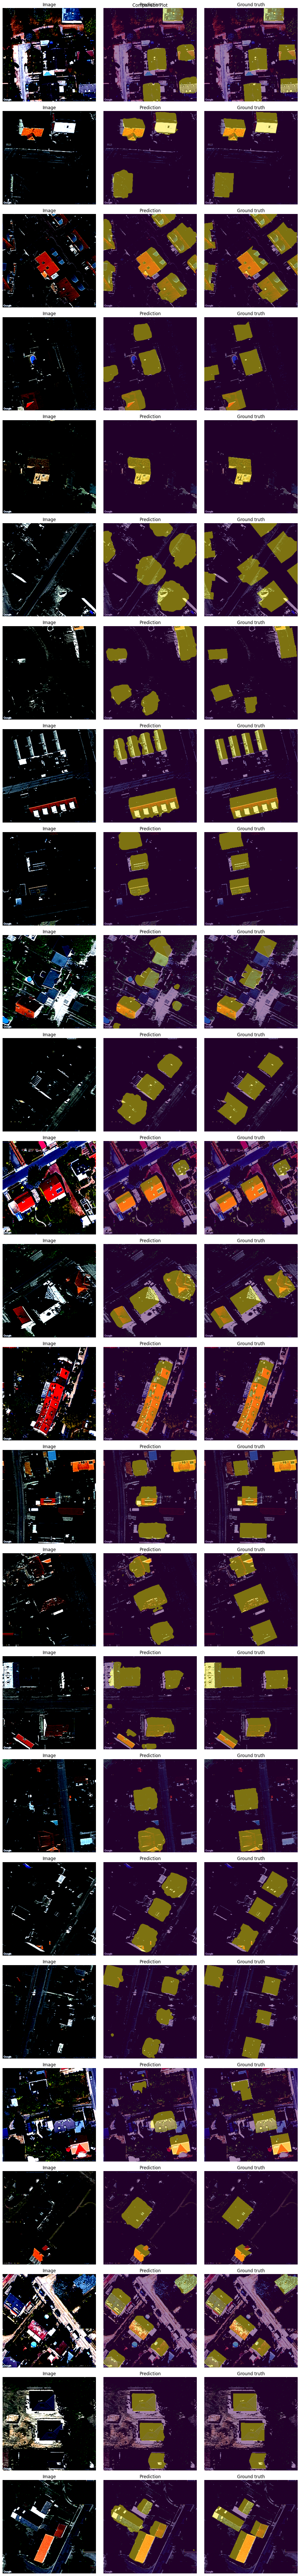

In [ ]:
# create a batch of IMG_BATCH<=25 images and plot it
IMG_BATCH=8
imgs_list=[]
masks_list=[]
for i,(imgs_batch,masks_batch) in enumerate(val_loader):
    imgs_list.append(imgs_batch)
    masks_list.append(masks_batch)
    if i>=IMG_BATCH-1:
        break
imgs=torch.cat(imgs_list,dim=0)
masks=torch.cat(masks_list,dim=0)

# use the predictor instantiated before to make predictions
preds=predictor.predict_batch(imgs)

# Plot 3 graphs -- image, predicted mask & mask -- for the full batch (25 images)
drs.viz.plot_batch(
    imgs,
    preds,
    masks,
    max_n=IMG_BATCH,
    title="Comparison Plot",
    save_path="comp_plot.png",
    show=True,
    overlay_alpha=0.5,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225)
)

## Test on the 5 test imgs

Next, we test our model on the 5 test images provided.

Saved plot to test_plot.png


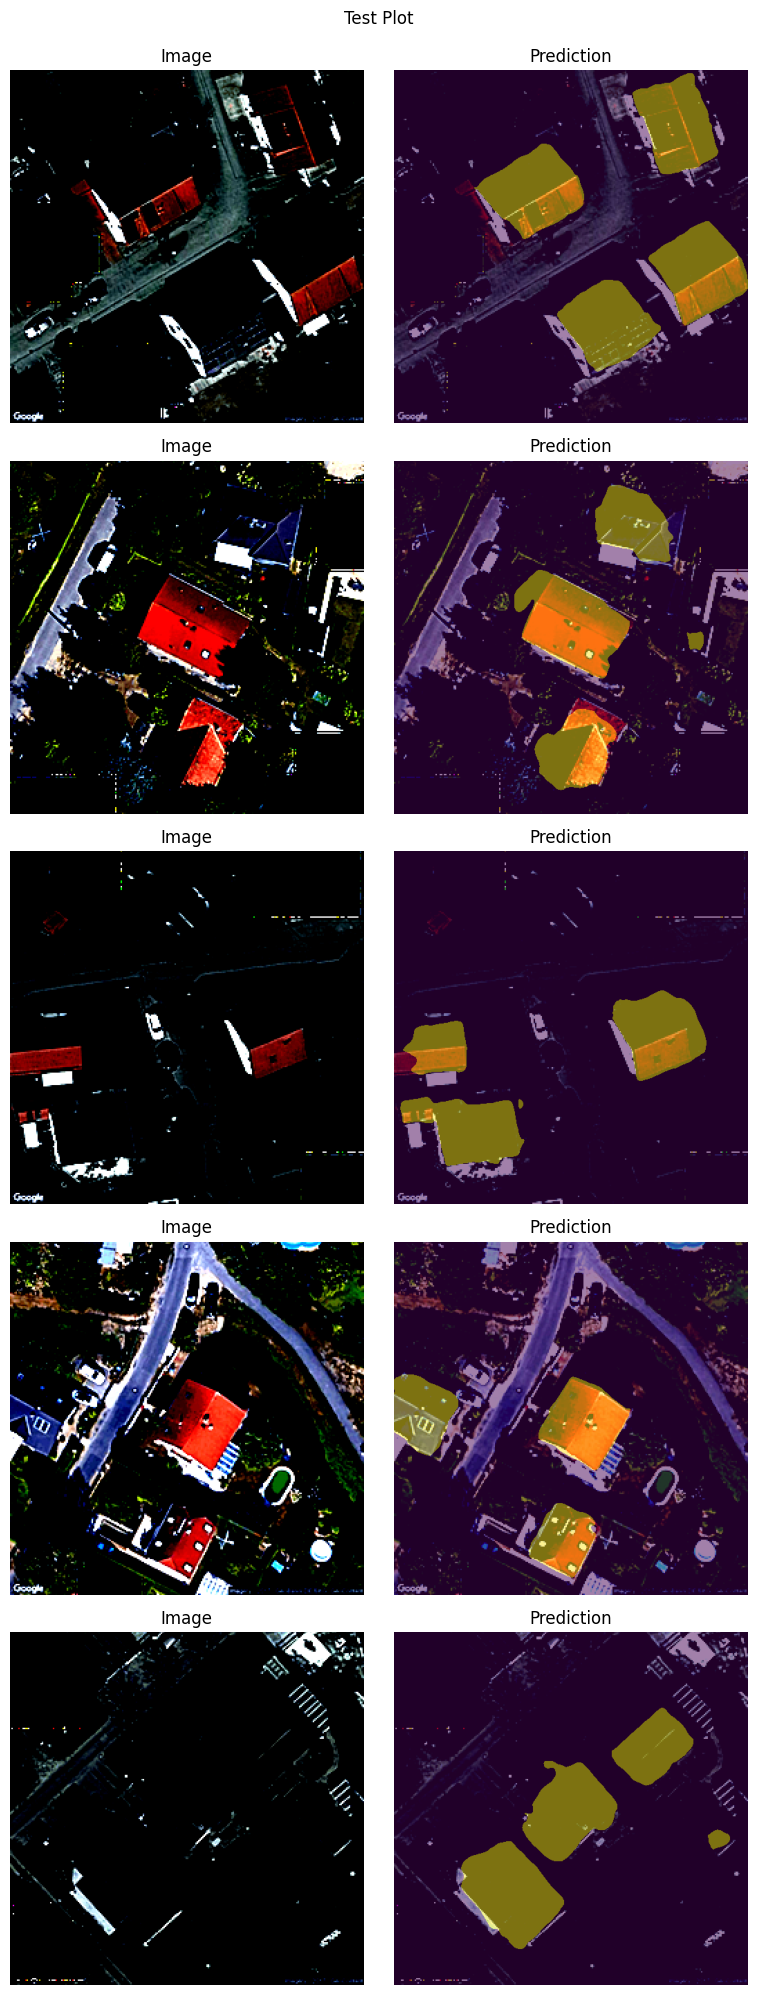

In [ ]:
# first create test dataset & dataloader (image_paths changed for `test_images` below)
test_ds = RoofDataset(mode="test", image_paths=test_images, image_size=RESIZE)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# Look at the full batch of 5 images
imgs_list=[]
for i,(imgs_batch,_) in enumerate(test_loader):
    imgs_list.append(imgs_batch)
    if i>=4:
        break
imgs=torch.cat(imgs_list,dim=0)
preds=predictor.predict_batch(imgs)

# visualize test images and predictions
viz.plot_batch(
    imgs,
    preds,
    max_n=5,
    title="Test Plot",
    save_path="test_plot.png",
    show=True,
    overlay_alpha=0.5,
)